In [14]:
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import jax.numpy as np
from scipy.optimize import root
from jax import jacrev

In [15]:
%matplotlib ipympl

In [16]:
# Define your differentiable function (example form)
def F(in1, in2, in3, out1, out2, out3):
    y1 = in1**2 + in2 - out1
    y2 = in2**2 + in3 - out2
    y3 = in3**2 + in1 - out3
    return np.array([y1, y2, y3])

# Jacobians with JAX
dFdi1 = jacrev(F, 0)
dFdi2 = jacrev(F, 1)
dFdi3 = jacrev(F, 2)
dFdo1 = jacrev(F, 3)
dFdo2 = jacrev(F, 4)
dFdo3 = jacrev(F, 5)

In [17]:
# Implicit function derivative for 3D (di/do)
def fprime(i1, i2, i3, o1, o2, o3):
    dFdo = np.array([dFdo1(i1, i2, i3, o1, o2, o3),
                     dFdo2(i1, i2, i3, o1, o2, o3),
                     dFdo3(i1, i2, i3, o1, o2, o3)]).squeeze().T

    dFdi = np.array([dFdi1(i1, i2, i3, o1, o2, o3),
                     dFdi2(i1, i2, i3, o1, o2, o3),
                     dFdi3(i1, i2, i3, o1, o2, o3)]).squeeze().T

    di_do = -dFdo @ np.linalg.pinv(dFdi)
    return di_do

In [18]:
# Ellipsoid definition
p = np.array([1.0, 1.0, 1.0])  # Ellipsoid center
phi = np.linspace(0, 2 * np.pi, 20)
theta = np.linspace(0, np.pi, 10)
phi, theta = np.meshgrid(phi, theta)
a, b, c = 0.5, 0.3, 0.2

pX = p[0] + a * np.sin(theta) * np.cos(phi)
pY = p[1] + b * np.sin(theta) * np.sin(phi)
pZ = p[2] + c * np.cos(theta)

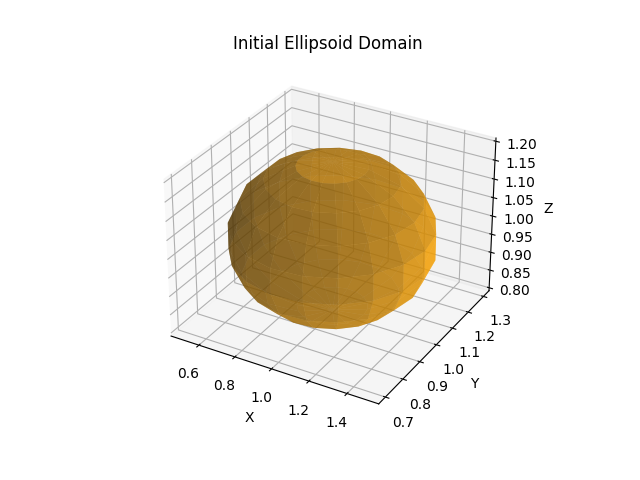

In [19]:
# Plot Domain (output) immediately after defining it
fig0 = plt.figure()
ax0 = fig0.add_subplot(111, projection='3d')
ax0.plot_surface(pX, pY, pZ, color='orange', alpha=0.6)
ax0.set_title('Initial Ellipsoid Domain')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('Z')
plt.show()

In [20]:
# Path for continuation
path = np.vstack((pX.flatten(), pY.flatten(), pZ.flatten())).T
dpath = path[1:] - path[:-1]

In [21]:
# Initial solution
sol = root(lambda X, o: F(X[0], X[1], X[2], *o), [1.0, 1.0, 1.0], args=(path[0],))
i1, i2, i3 = sol.x
o1, o2, o3 = path[0]

inp, out = [[i1, i2, i3]], [[o1, o2, o3]]
print(sol.message)

The solution converged.


In [22]:
# Continuation integration loop (RK4)
for h in dpath:
    do1, do2, do3 = h

    k1 = fprime(i1, i2, i3, o1, o2, o3) @ h
    k2 = fprime(*(np.array([i1, i2, i3]) + k1 / 2), *(np.array([o1, o2, o3]) + h / 2)) @ h
    k3 = fprime(*(np.array([i1, i2, i3]) + k2 / 2), *(np.array([o1, o2, o3]) + h / 2)) @ h
    k4 = fprime(*(np.array([i1, i2, i3]) + k3), *(np.array([o1, o2, o3]) + h)) @ h

    di = (k1 + 2*k2 + 2*k3 + k4) / 6

    i1, i2, i3 = np.array([i1, i2, i3]) + di
    o1, o2, o3 = np.array([o1, o2, o3]) + h

    if not np.all(np.abs(F(i1, i2, i3, o1, o2, o3)) < 1e-2):
        sol = root(lambda X, o: F(X[0], X[1], X[2], *o), [i1, i2, i3], args=([o1, o2, o3],))
        if sol.success:
            i1, i2, i3 = sol.x
        else:
            print("Correction failed at", o1, o2, o3)

    inp.append([i1, i2, i3])
    out.append([o1, o2, o3])

inp, out = np.array(inp), np.array(out)

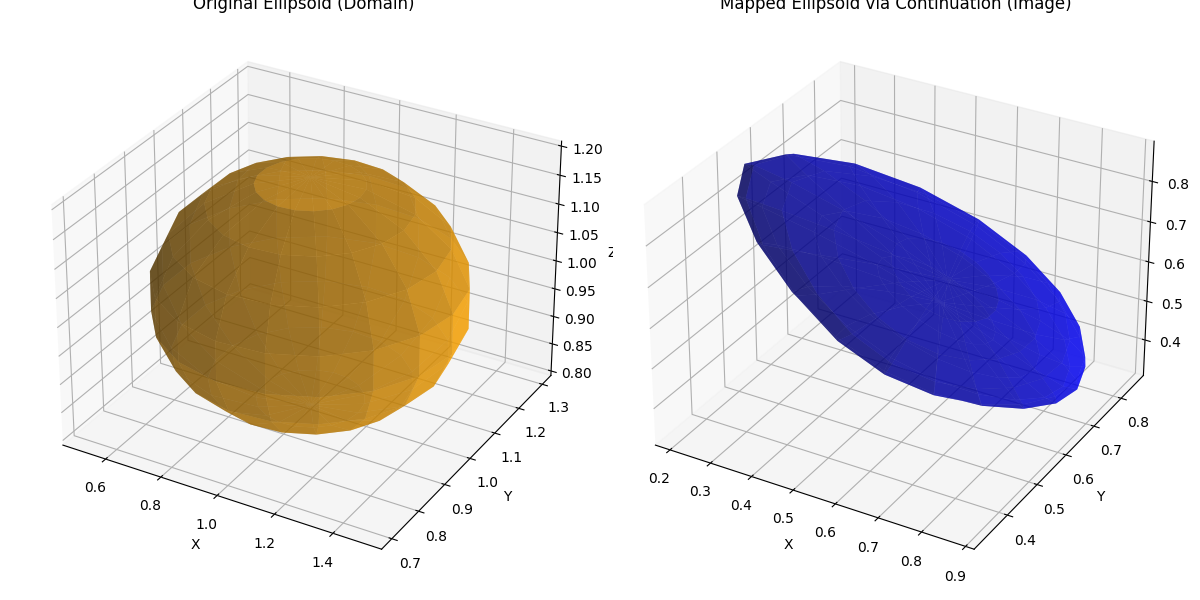

In [23]:
# Visualization of both original and mapped ellipsoid surfaces
X_mapped = inp[:, 0].reshape(theta.shape)
Y_mapped = inp[:, 1].reshape(theta.shape)
Z_mapped = inp[:, 2].reshape(theta.shape)

fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(121, projection='3d')
ax1.plot_surface(pX, pY, pZ, color='orange', alpha=0.6)
ax1.set_title('Original Ellipsoid (Domain)')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')

ax2 = fig1.add_subplot(122, projection='3d')
ax2.plot_surface(X_mapped, Y_mapped, Z_mapped, color='blue', alpha=0.6)
ax2.set_title('Mapped Ellipsoid via Continuation (Image)')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
plt.tight_layout()
plt.show()

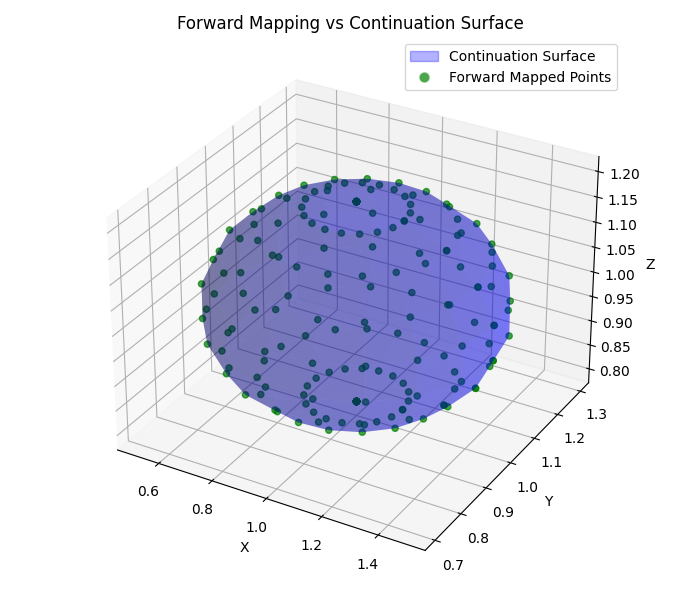

In [24]:
# Forward mapping definition
def forward_map(i1, i2, i3):
    return np.array([i1**2 + i2, i2**2 + i3, i3**2 + i1]).T

# Run forward mapping with inverse mapping inputs
forward_mapped = forward_map(inp[:,0], inp[:,1], inp[:,2])

# Comparison plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig2 = plt.figure(figsize=(7,6))
ax3 = fig2.add_subplot(111, projection='3d')
ax3.plot_surface(pX, pY, pZ, color='blue', alpha=0.3)
ax3.scatter(forward_mapped[:,0], forward_mapped[:,1], forward_mapped[:,2], color='green', alpha=0.7)

legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='Continuation Surface'),
    Line2D([0], [0], marker='o', color='w', label='Forward Mapped Points',
           markerfacecolor='green', markersize=8, alpha=0.7)
]

ax3.legend(handles=legend_elements)
ax3.set_title('Forward Mapping vs Continuation Surface')
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
plt.tight_layout()
plt.show()

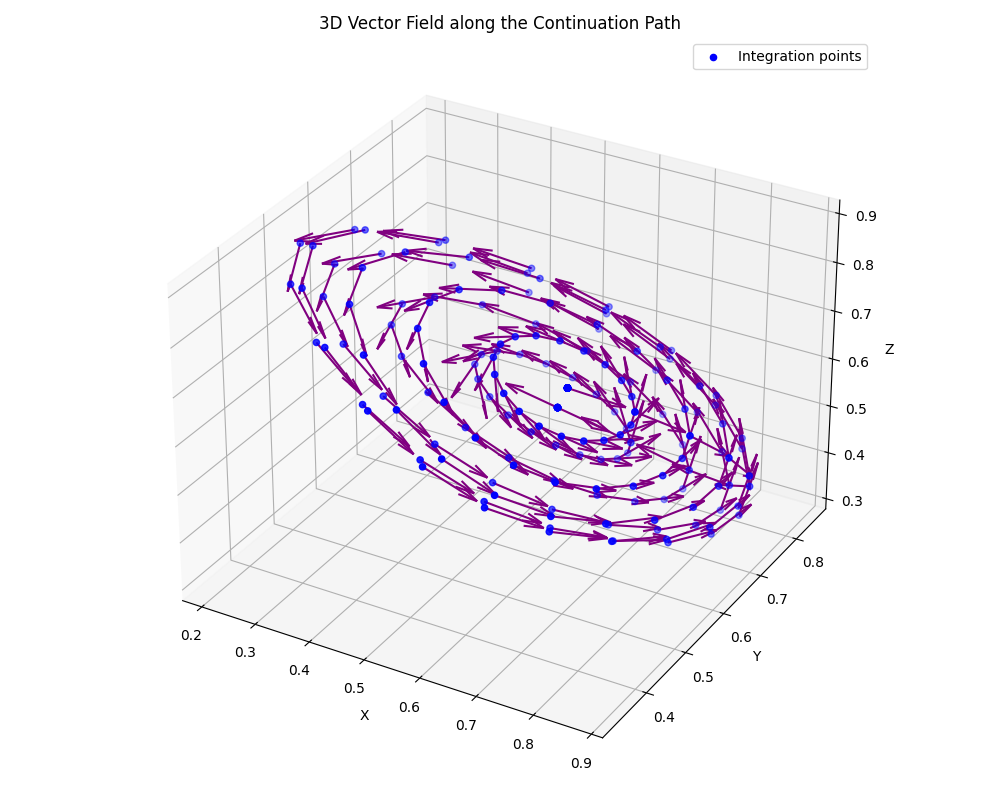

In [25]:

inp, out = inp.T, out.T

# Define a similar "fprime_trans" function adapted clearly for 3D
def fprime_trans_3d(y_current, y_next, inp_current):
    Jac = fprime(*inp_current, *y_current)
    return Jac @ (y_next - y_current)

# Computing estimated vector fields
dx_est_conc = np.zeros_like(inp)

for k in range(out.shape[1] - 1):
    dx = fprime_trans_3d(out[:, k], out[:, k + 1], inp[:, k])
    dx_est_conc = dx_est_conc.at[:, k].set(dx)

# 3D Quiver plot clearly visualizing vector fields
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(inp[0, :-1], inp[1, :-1], inp[2, :-1],
          dx_est_conc[0, :-1], dx_est_conc[1, :-1], dx_est_conc[2, :-1],
          length=0.1, normalize=True, color='purple')

# clearly plotting the integration points (path)
ax.scatter(inp[0], inp[1], inp[2], color='blue', s=20, label='Integration points')

# Setting labels and titles clearly
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Vector Field along the Continuation Path')
ax.legend()

plt.tight_layout()
plt.show()

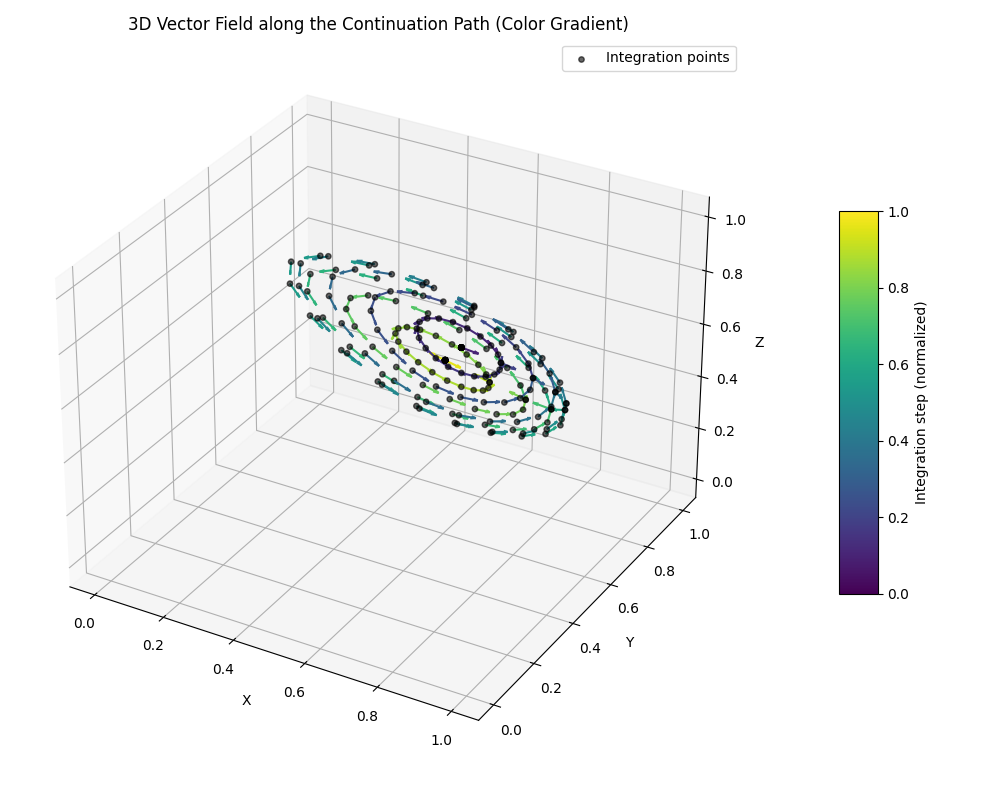

In [26]:
import matplotlib.cm as cm

# Create a colormap gradient based on arrow sequence
num_arrows = inp.shape[1] - 1
colors = cm.viridis(np.linspace(0, 1, num_arrows))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot arrows individually to allow color gradient
for k in range(num_arrows):
    ax.quiver(
        inp[0, k], inp[1, k], inp[2, k],
        dx_est_conc[0, k], dx_est_conc[1, k], dx_est_conc[2, k],
        length=0.05, normalize=True, color=colors[k]
    )

# Add integration points for clarity
ax.scatter(inp[0], inp[1], inp[2], color='black', s=15, alpha=0.6, label='Integration points')

# Titles and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Vector Field along the Continuation Path (Color Gradient)')

# Add a colorbar as a visual aid
mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(np.linspace(0, 1, num_arrows))
cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Integration step (normalized)')

ax.legend()
plt.tight_layout()
plt.show()